In [1]:
import pandas as pd
import numpy as np

import datetime as dt

from statsmodels.tsa.stattools import acf, pacf

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df = df.rename(columns={'date':'ds','value':'y'})
df

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [3]:
def time_series_plot(
    df,
    figsize = (7,5),
    time_series_name = None,  
    solo_plot = True, 
    ax = None,
):
    
    # Grab the current axis if none provided. 
    if solo_plot is True and ax is None:
        ax = None
    elif solo_plot is False and ax is None:
        ax=plt.gca()

    # Grab the name of the time series
    if time_series_name == None:
        time_series_name = df['y'].name

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    # Determine the horizontal label for the time series and ticker 
    if np.issubdtype(df['ds'], np.datetime64):
        time_series_id_label = 'Date'

    elif np.issubdtype(df['ds'], np.number):
        time_series_id_label = 'Series Number'
    else: 
        time_series_id_label = 'Row Number'

    marker = "o" if len(df['ds']) < 50 else "."

    ax.scatter(
        df['ds'], 
        df['y'],
        marker=marker, 
        s = 70, 
        color="grey", ec="k", alpha=1, 
        label = 'Eigenvalue'
    )

    ax.plot(
        df['ds'],
        df['y'],
        color='steelblue', alpha=1,
        linewidth=1
    )

    ax.set_xlabel(f'\n(x)  {time_series_id_label}', fontsize=12)
    ax.set_ylabel(f'(y)  {time_series_name}\n', fontsize=12)
    ax.set_title(f'\nTime Series {time_series_name}\n', fontsize=12)

    if solo_plot is True:
        plt.show()
        plt.close()
        return 

    return ax


In [4]:
def weekly_seasonal_boxplots(df, figsize=(7,5), solo_plot=True, ax=None):
    
    """
    Creates side-by-side boxplots showing weekly seasonality.
    """
    
    # Get Vals
    day_name_vals = df['ds'].dt.day_name()
    values = df['y']
    
    # Create DataFrame to Plot
    data = pd.DataFrame({'day_name':day_name_vals, 'values':values})
    data = data.pivot(columns='day_name', values = 'values')
    rename_dict = {
        'Monday':'Mon','Tuesday':'Tue','Wednesday':'Wed','Thursday':'Thu','Friday':'Fri','Saturday':'Sat', 'Sunday':'Sun'
    }
    col_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    data = data.rename(columns=rename_dict)[col_names]
    
    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax = data.boxplot(
        figsize=(7,5),
        grid=False,
        return_type='axes'
    )
    ax.set_title('\nWeekly\n', fontsize=15)
    
    return ax

In [5]:
def monthly_seasonal_boxplots(df, figsize=(7,5), solo_plot=True, ax=None):
    
    """
    Creates side-by-side boxplots showing monthly seasonality.
    """

    # Get Vals
    month_name_vals = df['ds'].dt.month_name()
    values = df['y']
        
    # Create DataFrame to Plot
    data = pd.DataFrame({'month_name':month_name_vals, 'values':values})
    data = data.pivot(columns='month_name', values = 'values')

    rename_dict = {
        'January':'Jan','February':'Feb','March':'Mar','April':'Apr','May':'May','June':'Jun',
        'July':'Jul', 'August':'Aug','September':'Sep','October':'Oct','November':'Nov','December':'Dec'
    }
    col_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    data = data.rename(columns=rename_dict)[col_names]

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    ax = data.boxplot(
        figsize=(7,5),
        grid=False,
        return_type='axes'
    )
    ax.set_title('\nMonthly\n', fontsize=15)
    
    return ax

In [6]:
def yearly_seasonal_boxplots(df, figsize=(18,5), solo_plot=True, ax=None):
    
    """
    Creates side-by-side boxplots showing yearly seasonality.
    """
    
     # Get Vals   
    year_vals = df['ds'].dt.year
    values = df['y']

    # Create DataFrame to Plot
    data = pd.DataFrame({'year':year_vals, 'values':values})
    data = data.pivot(columns='year', values = 'values')
    data = data[data.columns.sort_values()] # make sure the dates are in order
    

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax = data.boxplot(
        grid=False,
        return_type='axes'
    )
    ax.set_title('\nYearly\n', fontsize=15)
    
    return ax

In [7]:
def seasonal_boxplots(df, figsize=(12,9)):
    
    fig = plt.figure(constrained_layout=True, figsize=figsize) 
    specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) 

    ax1 = fig.add_subplot(specs[0, 0])
    ax1 = weekly_seasonal_boxplots(df, figsize=(figsize[0]/2,5), solo_plot=False, ax=ax1)
    
    ax2 = fig.add_subplot(specs[0, 1]) 
    ax2 = monthly_seasonal_boxplots(df, figsize=(figsize[0]/2,5), solo_plot=False, ax=ax2)

    ax3 = fig.add_subplot(specs[1, :]) 
    ax3 = yearly_seasonal_boxplots(df, figsize=(figsize[0],5), solo_plot=False, ax=ax3)
    
    plt.show()

In [8]:
def time_series_diagnostic_values(df):

    num_lags= 25 if len(df) >=25 else len(df)

    acf_values, acf_interval, ljung_box_vals, p_vals = acf(
        x=df['y'],
        nlags=num_lags,
        qstat=True,
        alpha=0.05, 
        fft=False
    )

    pacf_values, pacf_interval = pacf(
        x=df['y'],
        nlags=num_lags,
        method='ywadjusted',
        alpha=0.05
    )

    autocorrelations = pd.DataFrame(
        {'Lag':np.arange(num_lags+1),
         'AutoCorr':[val for val in acf_values],
         'ACF Inervals':[val for val in acf_interval],
         'Ljung_Box Q':[val for val in np.insert(ljung_box_vals, 0, None)],
         'p-Value':[val for val in np.insert(p_vals, 0, None)],
         'Partial':[val for val in pacf_values],
         'PACF Intervals':[val for val in pacf_interval]
        }
    )

    return autocorrelations

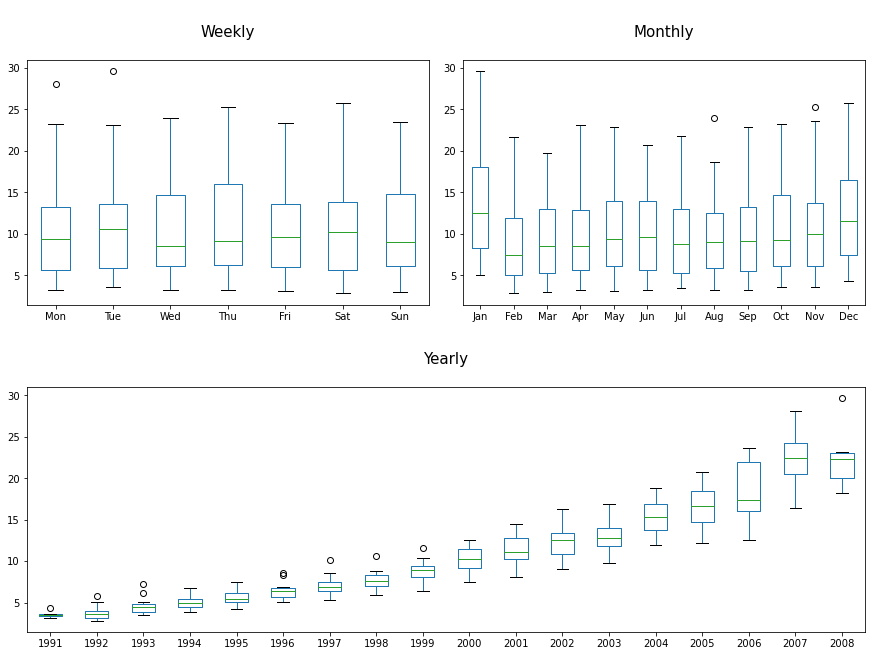

In [9]:
seasonal_boxplots(df, figsize=(12,9))

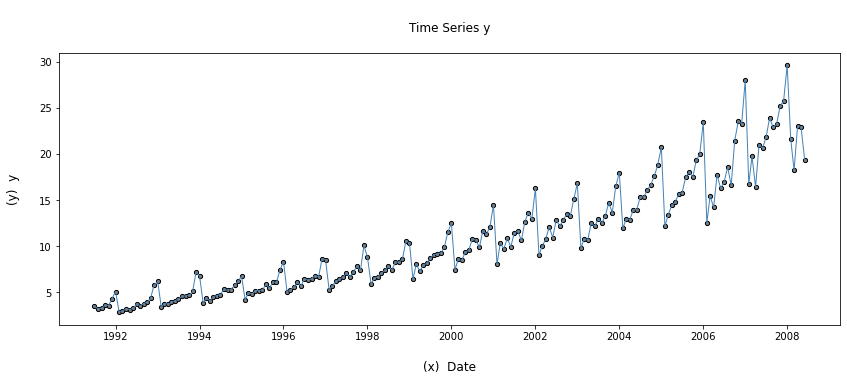

In [10]:
time_series_plot(df,figsize = (14,5))

In [11]:
diagnostic_vals = time_series_diagnostic_values(df)
diagnostic_vals

,Lag,AutoCorr,ACF Inervals,Ljung_Box Q,p-Value,Partial,PACF Intervals
0,0,1.000000,"[1.0, 1.0]",NaN,NaN,1.000000,"[1.0, 1.0]"
1,1,0.920568,"[0.783343220940938, 1.0577930742373]",175.433787,4.813705e-40,0.925103,"[0.7878780394019681, 1.0623278926983302]"
2,2,0.887825,"[0.662555043754761, 1.1130953392178884]",339.417587,1.978826e-74,0.282971,"[0.14574613818948684, 0.4201959914858488]"
3,3,0.853859,"[0.5702522262049217, 1.1374650205070798]",491.848576,2.787243e-106,0.075976,"[-0.06124912956307765, 0.2132007237332843]"
4,4,0.840528,"[0.5120614722257795, 1.1689953449082848]",640.295836,2.939213e-137,0.169215,"[0.03199001764043741, 0.30643987093679936]"
5,5,0.825238,"[0.45849823527994493, 1.1919771459017707]",784.110251,3.167141e-167,0.093703,"[-0.04352168241302497, 0.230928170883337]"
6,6,0.796297,"[0.3961142864064361, 1.1964788643852304]",918.690676,3.419747e-195,-0.063961,"[-0.20118567385830693, 0.07326417943805504]"
7,7,0.779502,"[0.35051847942547487, 1.2084846567868905]",1048.308626,4.383473e-222,0.056004,"[-0.08122053138585199, 0.19322932191050995]"
8,8,0.759533,"[0.3046584739909332, 1.2144065446619228]",1171.998472,1.075302e-247,0.016509,"[-0.12071610283603142, 0.15373375046033055]"
9,9,0.743376,"[0.26521603869487786, 1.2215357273558944]",1291.089683,2.599520e-272,0.004319,"[-0.13290588685938587, 0.1415439664369761]"
